<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Кросс-валидация" data-toc-modified-id="Кросс-валидация-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Кросс-валидация</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес-с-градиентным-бустингом" data-toc-modified-id="Случайный-лес-с-градиентным-бустингом-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Случайный лес с градиентным бустингом</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле _toxic_comments.csv_. 
- `text` — текст комментария,
- `toxic` — целевой признак.

## Подготовка

In [1]:
# Библиотеки
import time
from tqdm.notebook import tqdm_notebook as tqdm

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, auc, roc_curve
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
pd.set_option('display.max_colwidth', 280)

RANDOM_STATE = 123

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hm\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Некоторые функции

In [2]:
class hm:
    def plot_value_counts(series, n_values=25, fillna='NONE', figwidth=10):
        ''' Визуализация количества встречающихся значений в pd.Series

        Параметры
        ---
        `series` : pd.Series - датафрейм
        `column` : str - название столбца
        `n_values` : int - максимальное количество значений для отображения на диаграмме
        `fillna` : Any - значение, которым необходимо заполнить пропуски
        '''
        val_counts = series.fillna(fillna).value_counts()
        bar_values = val_counts.values[:n_values]
        bar_labels = val_counts.index[:n_values].astype('str')
        plt.figure(figsize=(figwidth, 0.5*min(len(val_counts), n_values)))
        ax = sns.barplot(x=bar_values, y=bar_labels)
        ax.set(title='"{}" value counts ({} / {})'
            .format(series.name, len(bar_labels), val_counts.shape[0]),
            xlim=[0, 1.075*bar_values.max()]
            )
        plt.bar_label(ax.containers[0])
        for i in range(len(bar_labels)):
            if bar_labels[i] == fillna:
                ax.patches[i].set_color('black')
        plt.show()

    def best_cv_models(grid, count):
        ''' Выводит таблицу с показателями моделей, показавших наилучшие значения метрики на кроссвалидации.

        Принимает  
            : `grid` - результат GridSearchCV после fit(), 
            : `count` - количество лучших моделей для вывода
        Возвращает : pd.DataFrame c параметрами моделей
        '''

        print('Estimator: {}'.format(grid.estimator))
        print('Tested {} models. Splits: {}'.format(
            len(grid.cv_results_['params']), grid.cv))
        print('Best score = {}\n'.format(grid.best_score_))
        best_idx = grid.cv_results_['rank_test_score'].argsort()[:count]

        results = {}
        results['test score'] = grid.cv_results_['mean_test_score'][best_idx]
        if 'mean_train_score' in grid.cv_results_.keys():
            results['train score'] = grid.cv_results_['mean_train_score'][best_idx]
        results['fit time, s'] = grid.cv_results_['mean_fit_time'][best_idx]
        results['score time, s'] = grid.cv_results_['mean_score_time'][best_idx]

        return pd.DataFrame(results).join(
               pd.DataFrame([grid.cv_results_['params'][i] for i in best_idx]))

    def roc_curve_plot(models, X_test, y_test, title='ROC Curve', labels=None, figsize=(10,8)):
        ''' Функция построения ROC кривой для моделей из переданнойго словаря

        Принимает:
        '''

        plt.figure(figsize=figsize)
        for name, model in models.items():
            pred = model.predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, pred)
            roc_auc = auc(fpr, tpr)
            plt.title(title)
            plt.plot(fpr, tpr, label='AUC = %0.4f (%s)' % (roc_auc, name))
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.grid()
        plt.xlim([0, 1]), plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    
    def test_model(model, X_train, X_test, y_train, y_test, score_func=None):
        ''' 
        - Обучение модели `model` на выборках `X_train`, `y_train`
        - Предсказание обученной модели на наборе `X_test`
        - Вычисление метрики `score_func` на полученных предсказаниях и наборе `y_test`
        
        `score_func` : sklearn.metrics  

        Возвращает score, время обучения, время пердсказаний и сами предсказания в виде словаря
        '''
        # обучение
        t_beg = time.time()
        model.fit(X_train, y_train)
        time_fit = time.time() - t_beg
        # предсказания
        t_beg = time.time()
        y_pred = model.predict(X_test)
        time_predict = time.time() - t_beg
        # метрика
        score = score_func(y_test, y_pred)

        return {'score test': score,
                'fit time': time_fit,
                'predict time': time_predict
                }

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
Duplicates count: 0


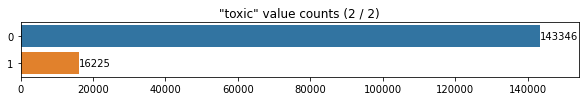

In [3]:
df = pd.read_csv('../datasets/toxic_comments.csv')
df.info()
print('Duplicates count:', df['text'].duplicated().sum())
hm.plot_value_counts(df['toxic'])

Классы несбалансированы, поэтому для некоторых моделей необходимо будет их сбалансировать

In [4]:
df.sample(8)

,text,toxic
132400,"NATO names in bold. \n\nHi, regarding your valid correction to my edit on Tupolev Tu-160 regarding NATO names and WP:AIR consensus. Please forgive my confusion, since Tupolev Tu-142, Tupolev Tu-16, Tupolev Tu-22, Tupolev Tu-85, Tupolev Tu-95 and Tupolev Tu-98 all use bold NA...",0
156797,"In most cases the clips are adfunded. The application is only free for the end-user, not for companies which integrate the Clipgenerator as a subsystem on their websites for instance. So, the creation of clips is for free but not the commercial utilisation of the tool itself....",0
12196,"""== Expand ==\nCould somebody with adequate knowledge on this subject please expand it? I'd also need clarification on the following facts:\n Is this missile actually in development or is it something made uo by the press?\n Was there any mention of the signing of agreement b...",0
102611,"It has nothing to do with whether or not the edit is anonymous, or whether you take the edit seriously. It's based on Wikipedia's definition of vandalism, which pretty blatantly states that any good faith effort to edit is not vandalism. I fully agree the edit wasn't encycl...",0
149947,"""\n\n I'm too tired! \n\nI am way too tired to debate with Everyme right now and I am getting extremely tired of that user's high handed debating style. (I.E. I know the rules way better then you so shut up and stay in your corner!) So I am going to be quiet before I say so...",0
53218,"Is it even one of the few instances, or just the one? If there were others, they should go in the See Also. See Alsos on recent events make me uncomfortable with their stretching for relevance. (talk) 01:16, August 27, 2015 (UTC)",0
29874,for an idiot such as yourself,1
59517,"Category:Phillip K. Dick \n\nhi there... you appeared to list this in Wikipedia:Categories for deletion, but there's no category to delete, it's a red link. If you did intentionally list this category, you need also to reformat so it appears as a title in the TOC, and sign it.",0


Реализуем функцию для предобработки текстовых комментариев:
1. Приведём все комментарии к нижнему регистру
2. Удалим знаки пунктуации, оставив только латинские буквы
3. Разобъём каждый комментарий на отдельные слова
    - Удалим стоп-слова
    - Произведём лемматизацию слов
4. Соберём слова обратно в предложение, разделив пробелами

In [5]:
def text_preprocesing(text, stop_words=None, lemmatize=True, stemming=False):
    words = re.sub(r'[^a-z]', ' ', text.lower()).split()
    if stop_words:
        words = [w for w in words if not w in stop_words]
    if lemmatize:
        wnl = WordNetLemmatizer()
        words = [wnl.lemmatize(w) for w in words]
    if stemming:
        stm = SnowballStemmer('english')
        words = [stm.stem(w) for w in words]
    return ' '.join(words)

Произведём предобработку и разделим данные на обучающую и тестовую выборки

In [6]:
%%time
corpus = df['text'].apply(text_preprocesing, stop_words=stop_words)

X_train, X_test, y_train, y_test = (
    train_test_split(corpus, df['toxic'], test_size=0.25, random_state=RANDOM_STATE))

del corpus

CPU times: total: 25 s
Wall time: 25.4 s


Посмотрим на размер признакового пространсва после векторизации:

In [7]:
for r in [(1, 1), (2, 2), (1, 2)]:
    print('n-gram range {} : features count = {}'
          .format(r, TfidfVectorizer(ngram_range=r).fit_transform(X_train).shape[1]))

n-gram range (1, 1) : features count = 133505
n-gram range (2, 2) : features count = 2006158
n-gram range (1, 2) : features count = 2139663


При обучении на валидационной выборке ограничимся векторизацией отдельных слов, чтобы ускорить процесс обучения моделей и снизить объём используемой памяти.

Также, ограничим порог значимости признака `min_df = 1e-5`

## Кросс-валидация

Зададим общие параметры для кроссвалидации моделей
- метрика = `f1`
- количество разбиений = 3

Чтобы обеспечить "честное" тестирование и запускать векторизацию только на обучающей выборке, построим для каждой модели пайплайн. Иначе в модели будут учтены частоты слов из тестовой выборки.

In [8]:
cv_params = {'scoring': 'f1',
             'return_train_score': True,
             'cv': 3}

### Логистическая регрессия

In [9]:
%%time
pipe = Pipeline([('vct', TfidfVectorizer(min_df=1e-5)),
                 ('clf', LogisticRegression(class_weight='balanced', 
                                            random_state=RANDOM_STATE, 
                                            max_iter=500))
                ])
params = {'clf__solver': ['lbfgs', 'liblinear'],
          'clf__C': [0.1, 1, 10]
         } 
grid_lr = GridSearchCV(pipe, params, **cv_params, n_jobs=-1)
grid_lr.fit(X_train, y_train)
hm.best_cv_models(grid_lr, 10)

Estimator: Pipeline(steps=[('vct', TfidfVectorizer(min_df=1e-05)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=123))])
Tested 6 models. Splits: 3
Best score = 0.7650858659720873

CPU times: total: 30.3 s
Wall time: 30.8 s


,test score,train score,"fit time, s","score time, s",clf__C,clf__solver
0,0.765086,0.929914,12.493668,1.695969,10.0,lbfgs
1,0.765068,0.929879,5.972629,1.449563,10.0,liblinear
2,0.747829,0.847238,7.063677,2.564332,1.0,liblinear
3,0.747811,0.847203,8.938337,2.457663,1.0,lbfgs
4,0.708487,0.746844,6.307671,2.611998,0.1,lbfgs
5,0.708315,0.746723,5.758669,2.803336,0.1,liblinear


- решатель `liblinear` предпочтительнее, поскольку работает быстрее, выдавая практически такой же скор
- C большими значениями параметра регуляризации `C` модель склонна к переобучению

In [10]:
%%time
pipe = Pipeline([('vct', TfidfVectorizer(min_df=1e-5)),
                 ('clf', LogisticRegression(class_weight='balanced',
                                            random_state=RANDOM_STATE,
                                            solver='liblinear',
                                            max_iter=500))
                ])
params = {'vct__ngram_range': [(1, 1), (1, 2)], 
          'clf__C': [1, 10]
          }
grid_lr = GridSearchCV(pipe, params, **cv_params, n_jobs=-1)
grid_lr.fit(X_train, y_train)
hm.best_cv_models(grid_lr, 10)

Estimator: Pipeline(steps=[('vct', TfidfVectorizer(min_df=1e-05)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=123, solver='liblinear'))])
Tested 4 models. Splits: 3
Best score = 0.7811041402627422

CPU times: total: 35.9 s
Wall time: 51 s


,test score,train score,"fit time, s","score time, s",clf__C,vct__ngram_range
0,0.781104,0.988857,27.104000,3.110334,10,"(1, 2)"
1,0.765068,0.929879,5.892669,1.821665,10,"(1, 1)"
2,0.747829,0.847238,4.699003,1.938996,1,"(1, 1)"
3,0.746663,0.915041,23.613332,3.966669,1,"(1, 2)"


Использование векторизации на N-граммах позволяет поднять скор. Однако переобучение на таком большом количестве признаков ещё сильнее


### Случайный лес с градиентным бустингом

Воспользуемся классификатором LightGBM

In [11]:
%%time
pipe = Pipeline([('vct', TfidfVectorizer(min_df=1e-5)),
                 ('clf', LGBMClassifier(random_state=RANDOM_STATE))])

params = {'clf__max_depth': [40, 50, 60],
          'clf__learning_rate': [0.1, 0.2],
          'clf__num_leaves': [40, 50, 60],
          'clf__n_estimators': [100, 200]
         }
grid_lgbm = GridSearchCV(pipe, params, **cv_params)
grid_lgbm.fit(X_train, y_train)
hm.best_cv_models(grid_lgbm, 10)

Estimator: Pipeline(steps=[('vct', TfidfVectorizer(min_df=1e-05)),
                ('clf', LGBMClassifier(random_state=123))])
Tested 36 models. Splits: 3
Best score = 0.7751680504275065

CPU times: total: 5h 59min 26s
Wall time: 36min 59s


,test score,train score,"fit time, s","score time, s",clf__learning_rate,clf__max_depth,clf__n_estimators,clf__num_leaves
0,0.775168,0.909754,13.558183,1.265667,0.2,50,100,60
1,0.774716,0.950628,19.740758,1.398691,0.2,60,200,50
2,0.774716,0.950628,19.196881,1.421511,0.2,50,200,50
3,0.774603,0.930613,16.846298,1.379182,0.2,40,200,40
4,0.774603,0.930613,17.572667,1.378641,0.2,60,200,40
5,0.774603,0.930613,16.805258,1.356840,0.2,50,200,40
6,0.774204,0.950457,18.807334,1.383840,0.2,40,200,50
7,0.774089,0.963418,22.524400,1.475997,0.2,50,200,60
8,0.773862,0.963660,22.283341,1.500012,0.2,60,200,60
9,0.773092,0.889857,12.054666,1.254758,0.2,50,100,50


На признаках векторизированных по отдельным словам лес LightGBM обучается дольше. Однако менее склонен к  переобучению


## Обучение

Обучим подобранные модели на тренировочном датасете. 

Лес также обучим на датасете, векторизированном на биграммах

In [21]:
best_lr = grid_lr.best_estimator_
lgbm_unigram = grid_lgbm.best_estimator_
lgbm_bigram = Pipeline([('vct', TfidfVectorizer(min_df=1e-5, ngram_range=(1,2))),
                        ('clf', LGBMClassifier(random_state=RANDOM_STATE,
                                               max_depth=50, learning_rate=0.2,
                                               num_leaves=60, n_estimators=100))
                        ])
models = {'LogisticRegression': best_lr,
          'LightGBM unigram': lgbm_unigram, 'LightGBM bigram': lgbm_bigram}

  0%|          | 0/3 [00:00<?, ?it/s]

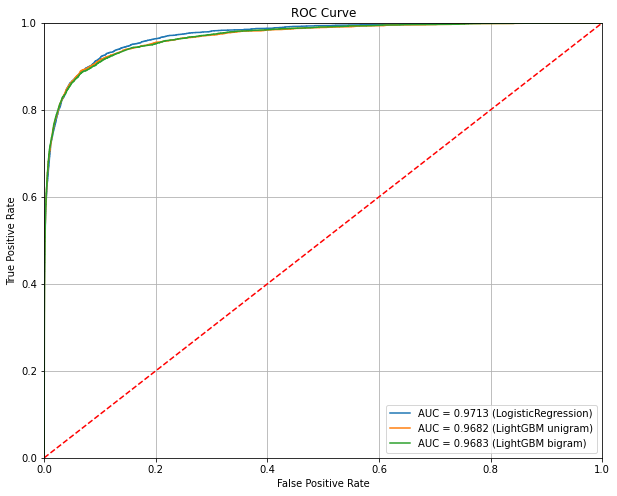

,LogisticRegression,LightGBM unigram,LightGBM bigram
score test,0.785697,0.785835,0.791620
fit time,13.086999,17.755000,34.861000
predict time,2.285003,1.183000,2.601999


In [22]:
scores_table = {}
for name, model in tqdm(models.items()):
    scores_table[name] = hm.test_model(
        model, X_train, X_test, y_train, y_test, f1_score)

hm.roc_curve_plot(models, X_test, y_test)
pd.DataFrame(scores_table)

## Выводы

Текстовые данные подготовлены очисткой от знаков пунктуации, приведением к нижнему регистру, лемматизацией слов

На всех рассмотренных моделях получено требуемое значение `f1`-метрики.

Лучше всего показывают себя модели, обученные на датасете с N-граммами (в нашем случае были рассмотрены пары слов)

Наибольшая площадь под ROC-кривой у модели логистической регрессии, обученной на данных векторизированных на униграммах и биграммах

Наивысшее значение метрики у классификатора LightGBM, обученного на данных векторизированных на униграммах и биграммах. Однако обучается такая модель в 2 раза дольше, чем на данных векторизированных только на униграммах